In [1]:
from sage.all import *
import networkx as nx
import random
import math
import os
import matplotlib.pyplot as plt

# BF 

def cM2_index_from_graph(G):
    return sum(abs(G.degree(u)**2 - G.degree(v)**2) for u, v in G.edges(labels=False))

def generate_join_graph(n, k):
    Polni = graphs.CompleteGraph(k)
    Izolirani = Graph(n - k)
    Polni.relabel({i: i for i in range(k)}, inplace=True)
    Izolirani.relabel({i: i + k for i in range(n - k)}, inplace=True)
    
    G = Graph()
    G.add_vertices(range(n))
    G.add_edges(Polni.edges())
    
    for u in range(k):
        for v in range(k, n):
            G.add_edge(u, v)
    
    return G

def is_join_graph(G):
    n = G.order()
    for k in range(1, n):
        H = generate_join_graph(n, k)
        if G.is_isomorphic(H):
            return True, k
    return False, None

def test_all_graphs(n, verbose=True):
    if verbose:
        print(f"Generating all connected graphs on n={n}...")
    
    rezultati = []
    
    for G in graphs.nauty_geng(f"-c {n}"):
        G = Graph(G)
        obj = cM2_index_from_graph(G)
        is_join, k_val = is_join_graph(G)
        edges = list(G.edges(labels=False))
        deg = {v: G.degree(v) for v in G.vertices()}
        
        rezultati.append({
            "graph": G,
            "objective": obj,
            "is_join": is_join,
            "k": k_val,
            "edges": edges,
            "deg": deg
        })
    
    max_obj = max(r["objective"] for r in rezultati)
    min_obj = min(r["objective"] for r in rezultati)
    
    max_grafi = [r for r in rezultati if r["objective"] == max_obj]
    min_grafi = [r for r in rezultati if r["objective"] == min_obj]
    
    if verbose:
        print(f"Total graphs: {len(rezultati)}")
        print(f"Min objective: {min_obj}")
        print(f"Max objective: {max_obj}")
    
    return rezultati, max_grafi, min_grafi

# NetworkX SA

class SA:
    def __init__(self, functions, G, _type='min', T=1000.0, u=0.995):
        self.functions = functions
        self.type = _type
        self.G = G.copy()
        self.E = self.cM2(G)
        self.T = T 
        self.u = u 
        self.best_state = G.copy()
        self.best_E = self.E
    
    @staticmethod
    def cM2(G):
        degrees = dict(G.degree())
        return sum(abs(degrees[u]**2 - degrees[v]**2) for u, v in G.edges())

    def accept(self, state_next, E_state, E_next):
        change = E_next - E_state
        if (change < 0 and self.type == 'min') or (change > 0 and self.type == 'max'):
            self.best_state = state_next
            self.best_E = E_next
            return True
        return random.random() < self.functions.cooling_function(change, self)
    
    def new_state(self):
        edges = list(self.G.edges())
        non_edges = list(nx.non_edges(self.G))
        if not non_edges:
            return self.G
        
        max_attempts = 50
        for _ in range(max_attempts):
            H = self.G.copy()
            u_v = self.functions.edge_to_remove(self, edges, non_edges)
            w_x = self.functions.edge_to_add(self, edges, non_edges)
            H.remove_edge(*u_v)
            H.add_edge(*w_x)
            if nx.is_connected(H):
                return H
        return self.G
            
    def simulated_annealing(self, verbose=False):
        while self.T > 1:
            state_next = self.new_state()
            E_next = self.cM2(state_next)
            if self.accept(state_next, self.E, E_next):
                self.G = state_next
                self.E = E_next
            self.T *= self.u
        
        if verbose:
            print(f"Best Energy: {self.best_E}")
        return (self.best_state, self.best_E)

class FunctionsMin2:
    def __init__(self):
        self.pick = None

    @staticmethod
    def cooling_function(change, milp):
        return math.exp(-change / milp.T)
    
    @staticmethod
    def cM2_test(milp, uv, wx):
        F = milp.G.copy() 
        F.remove_edge(*uv)
        F.add_edge(*wx)
        return milp.cM2(F)
    
    def edge_to_add(self, milp, edges, non_edges):
        if self.pick is None:
            raise ValueError("Unexpected.")
        return self.pick[1]
    
    def edge_to_remove(self, milp, edges, non_edges):
        candidates = [(uv, wx) for uv in edges for wx in non_edges]
        weights = {
            (uv, wx): self.cM2_test(milp, uv, wx) - milp.E
            for uv in edges for wx in non_edges
        }
        cf_weights = [
            self.cooling_function(change=weights[(uv, wx)], milp=milp) 
            for (uv, wx) in weights.keys()
        ]
        pick = random.choices(candidates, weights=cf_weights)[0]
        self.pick = pick
        return pick[0]

class FunctionsMax:
    def __init__(self):
        self.pick = None

    @staticmethod
    def cooling_function(change, milp):
        return math.exp(change / milp.T)
    
    @staticmethod
    def cM2_test(milp, uv, wx):
        F = milp.G.copy() 
        F.remove_edge(*uv)
        F.add_edge(*wx)
        return milp.cM2(F)
    
    def edge_to_add(self, milp, edges, non_edges):
        if self.pick is None:
            raise ValueError("Unexpected.")
        return self.pick[1]
    
    def edge_to_remove(self, milp, edges, non_edges):
        candidates = [(uv, wx) for uv in edges for wx in non_edges]
        weights = {
            (uv, wx): self.cM2_test(milp, uv, wx) - milp.E
            for uv in edges for wx in non_edges
        }
        cf_weights = [
            self.cooling_function(change=weights[(uv, wx)], milp=milp) 
            for (uv, wx) in weights.keys()
        ]
        pick = random.choices(candidates, weights=cf_weights)[0]
        self.pick = pick
        return pick[0]

def SA_networkx(n, k, minimize=True, T=5000.0, u=0.995, num_runs=2, verbose=False):
    """Wrapper za NetworkX SA - vrne Sage format."""
    m = n - 1 + k
    best_global = float('inf') if minimize else float('-inf')
    best_graph = None
    
    for run in range(num_runs):
        G = nx.gnm_random_graph(n, m, seed=None)
        while not nx.is_connected(G):
            G = nx.gnm_random_graph(n, m, seed=None)
        
        functions = FunctionsMin2() if minimize else FunctionsMax()
        sa = SA(
            functions=functions,
            G=G,
            _type='min' if minimize else 'max',
            T=T,
            u=u
        )
        best_state, best_E = sa.simulated_annealing(verbose=False)
        
        if (minimize and best_E < best_global) or (not minimize and best_E > best_global):
            best_global = best_E
            best_graph = best_state
        
        if verbose:
            print(f"  Run {run+1}: {best_E}")
    
    edges = [(min(u,v), max(u,v)) for u, v in best_graph.edges()]
    
    if verbose:
        print(f"Best: {best_global}")
    
    return dict(objective=best_global, edges=edges, method='SA')


Max za k=2
n=4, k=2: Brute-force... Exact objective=20
n=5, k=2: Brute-force... Exact objective=56
n=6, k=2: Brute-force... Exact objective=116
n=7, k=2: Brute-force... 

Exact objective=206
n=8, k=2: Brute-force... 

Exact objective=332
n=9, k=2: SA... 

SA objective=500.0
n=10, k=2: SA... 

SA objective=716.0
Max za k=3
n=4, k=3: Brute-force... Exact objective=0
n=5, k=3: Brute-force... Exact objective=72
n=6, k=3: Brute-force... Exact objective=132
n=7, k=3: Brute-force... 

Exact objective=222
n=8, k=3: Brute-force... 

Exact objective=348
n=9, k=3: SA... 

SA objective=516.0
n=10, k=3: SA... 

SA objective=732.0
Max za k=4
n=4, k=4: Brute-force... No graphs found with k=4
n=5, k=4: Brute-force... Exact objective=52
n=6, k=4: Brute-force... Exact objective=168
n=7, k=4: Brute-force... 

Exact objective=258
n=8, k=4: Brute-force... 

Exact objective=384
n=9, k=4: SA... 

SA objective=552.0
n=10, k=4: SA... 

SA objective=768.0


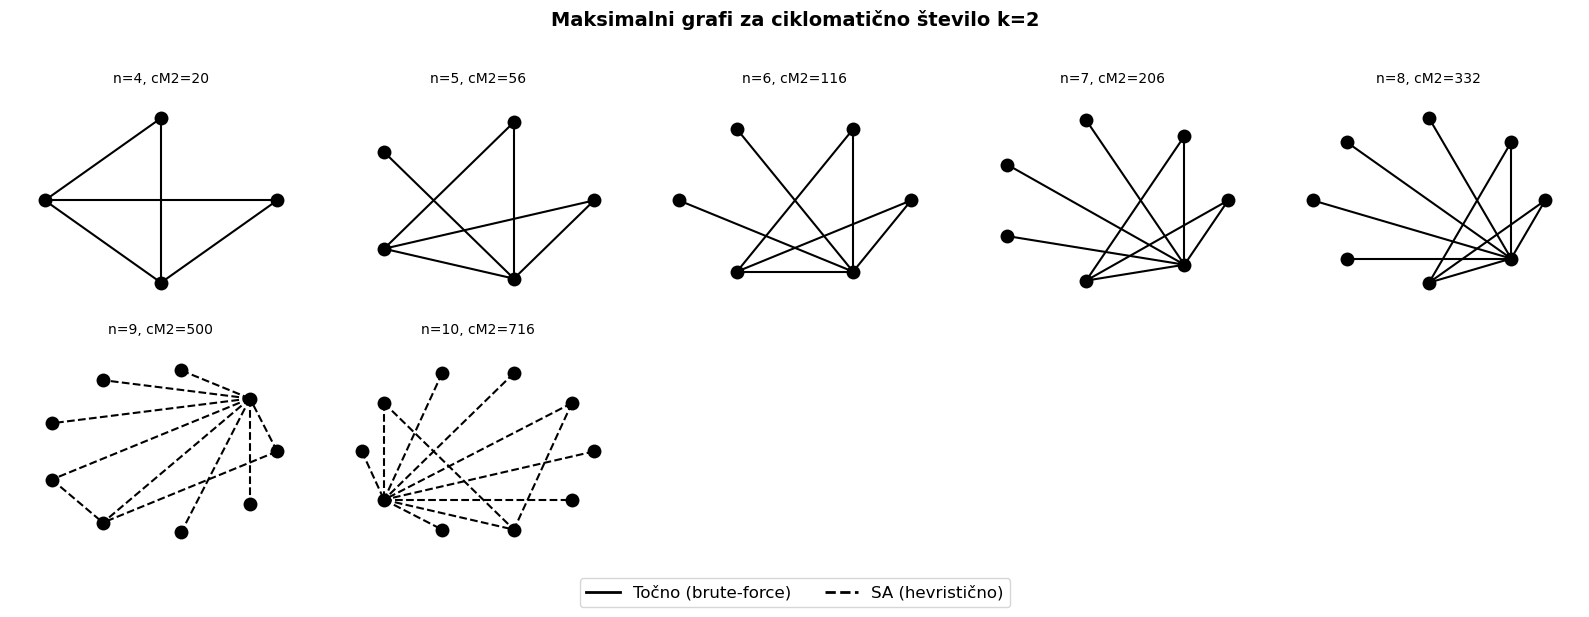

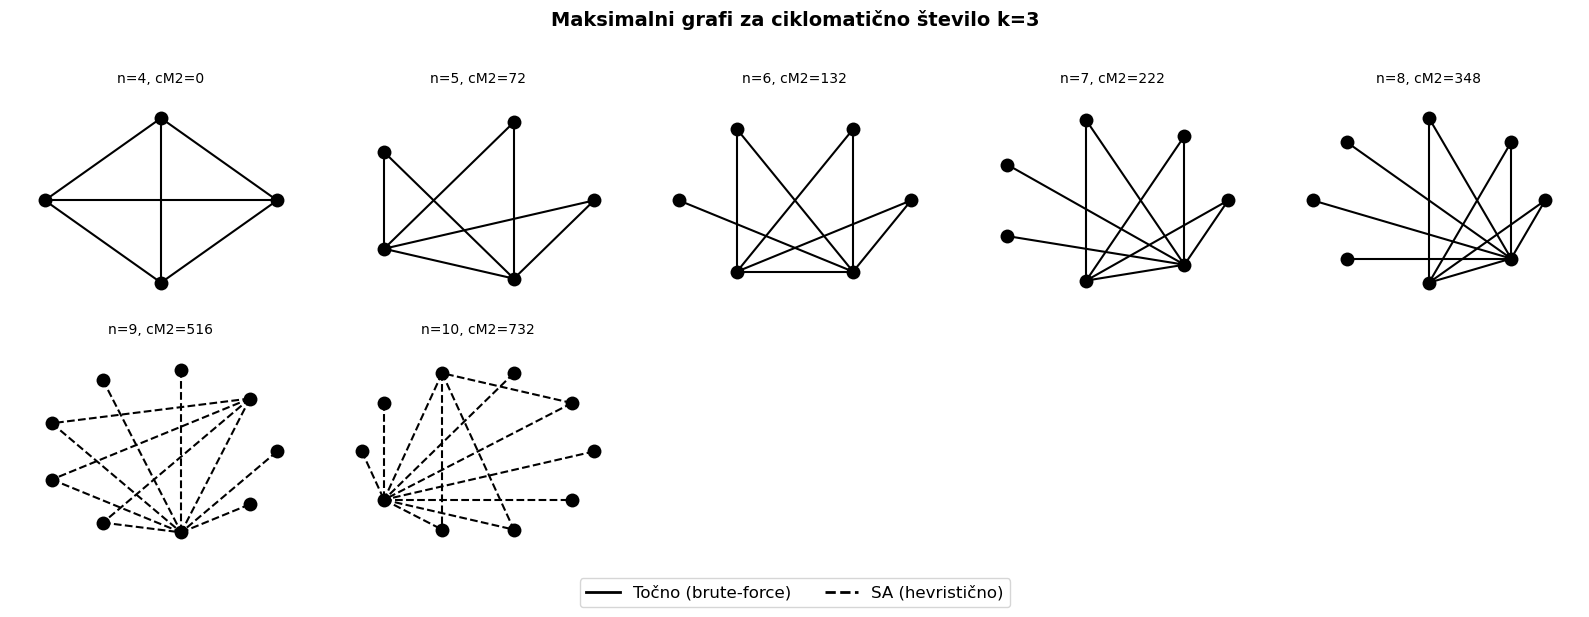

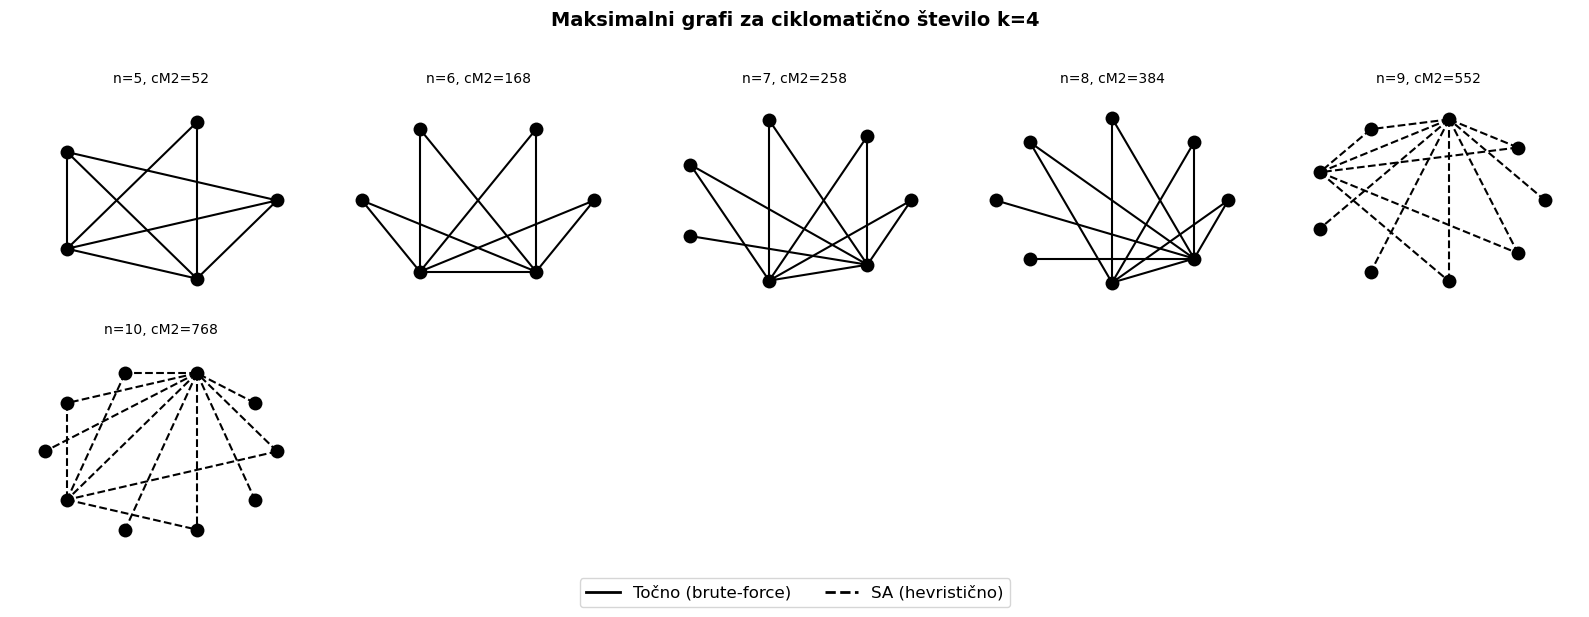

In [4]:
k_values = [2, 3, 4] 
n_range = range(4, 11)
BRUTE_FORCE_limit = 8 

all_max_results = {}

for k in k_values:
    print(f"Max za k={k}")
    results_k = []
    
    for n in n_range:
        if n <= BRUTE_FORCE_limit:
            print(f"n={n}, k={k}: Brute-force...", end=" ")
            vsi_rezultati, _, _ = test_all_graphs(n, verbose=False)
            
            m_target = n - 1 + k 
            grafi_s_k = [r for r in vsi_rezultati 
                        if len(r['edges']) == m_target]
            
            if grafi_s_k:
                max_obj = max(r['objective'] for r in grafi_s_k)
                max_graf = [r for r in grafi_s_k if r['objective'] == max_obj][0]
                
                results_k.append((n, max_graf, 'Exact'))
                print(f"Exact objective={max_obj}")
            else:
                print(f"No graphs found with k={k}")
        else:
            print(f"n={n}, k={k}: SA...", end=" ")
            res = SA_networkx(n, k, minimize=False, T=8000, u=0.996, 
                             num_runs=2, verbose=False)
            results_k.append((n, res, 'SA'))
            print(f"SA objective={res['objective']:.1f}")
    
    all_max_results[k] = results_k

# grafi

for k in k_values:
    results = all_max_results[k]
    num_graphs = len(results)
    
    cols = 5
    rows = (num_graphs + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3*rows))
    
    if rows == 1:
        axes_flat = list(axes) if hasattr(axes, '__iter__') else [axes]
    else:
        axes_flat = []
        for row in axes:
            if hasattr(row, '__iter__'):
                axes_flat.extend(row)
            else:
                axes_flat.append(row)
    
    for i in range(num_graphs, len(axes_flat)):
        axes_flat[i].axis('off')
    
    for idx, (n, res, method) in enumerate(results):
        ax = axes_flat[idx]
        
        if 'graph' in res:
            G = res['graph']
        else:
            G = Graph()
            G.add_vertices(range(n))
            G.add_edges(res['edges'])
            
        pos_dict = {}
        vertices = sorted(G.vertices())
        for i, vertex in enumerate(vertices):
            angle = 2 * math.pi * i / len(vertices)
            pos_dict[vertex] = [math.cos(angle), math.sin(angle)]
        
        linestyle = '-' if method == 'Exact' else '--'

        for edge in G.edges(labels=False):
            u, v = edge
            x_coords = [pos_dict[u][0], pos_dict[v][0]]
            y_coords = [pos_dict[u][1], pos_dict[v][1]]
            ax.plot(x_coords, y_coords, 'k' + linestyle, linewidth=1.5)
        
        for vertex in vertices:
            ax.plot(pos_dict[vertex][0], pos_dict[vertex][1], 'ko', 
                    markersize=10, markerfacecolor='black', markeredgewidth=0)
        
        ax.set_title(f'n={n}, cM2={int(res["objective"])}', 
                     fontsize=10, pad=8)
        ax.set_xlim(-1.3, 1.3)
        ax.set_ylim(-1.3, 1.3)
        ax.axis('off')

    plt.suptitle(f'Maksimalni grafi za ciklomatično število k={k}', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=2, linestyle='-', 
               label='Točno (brute-force)'),
        Line2D([0], [0], color='black', linewidth=2, linestyle='--', 
               label='SA (hevristično)')
    ]
    fig.legend(handles=legend_elements, loc='lower center', 
               ncol=2, fontsize=12, frameon=True, bbox_to_anchor=(0.5, -0.03))
    
    plt.tight_layout(rect=[0, 0.04, 1, 0.96])
    
    os.makedirs('images/maximal_graphs', exist_ok=True)
    filename = f'images/maximal_graphs/maximal_k{k}_final.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
